In [13]:
isLocalServer = True
sys_path_to_be_added = '/notebook/personal/ksuchoi216/temp_experiment_analysis/'
config_path = './configs/config.json'

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os

def checkLocalServer(isLocalServer, sys_path_to_be_added=None):
    print('='*60)
    print(f'isLocalServer is {isLocalServer}')
    print('='*60)
    
    if isLocalServer is True:
        if sys_path_to_be_added not in sys.path:
            sys.path.insert(0, sys_path_to_be_added)
            os.chdir(sys_path_to_be_added)

checkLocalServer(isLocalServer, sys_path_to_be_added)

!pwd
print('='*60)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
isLocalServer is True
/notebook/personal/ksuchoi216/temp_experiment_analysis


# FSR Distribution

Copyright © 2022 Algorigo Inc. All Rights Reserved.


In [14]:
import os
import sys
import time
from datetime import datetime
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lib.biosignal.signal_process.signalgo as signalgo

In [15]:
PATH_SOURCE = './data/temp_test/'

CURRENT_DATA = PATH_SOURCE + 'dataset/220209/test1'

RATIO = 0.5464516840547095

PATH_DATA_FSR = f'{CURRENT_DATA}/fsr.csv'
PATH_DATA_KEY = f'{CURRENT_DATA}/key.csv'

## FSR

In [16]:
df_fsr = pd.read_csv(PATH_DATA_FSR)
df_key = pd.read_csv(PATH_DATA_KEY)

# display( df_fsr.head() )
# display( df_key.head() )

__min = df_key.timestamp.min()
__max = df_key.timestamp.max()
df_fsr = df_fsr[ (df_fsr.timestamp >= __min) & (df_fsr.timestamp <= __max) ]

df_fsr.index = df_fsr.timestamp
# df_fsr = df_fsr.set_index('timestamp')
df_key = df_key.set_index('timestamp')
df_key_re = df_key.reindex(df_fsr.index, method='ffill') # nearest

df_fsr['key'] = df_key_re['key']
df_fsr = df_fsr.dropna(subset=['key']).reset_index(drop=True)
display( df_fsr.head() )
print( df_fsr.amp_sensor.unique() )
print( df_fsr.sens_sensor.unique() )

df = df_fsr.copy()
df['time_sec'] = (df.timestamp - df.timestamp.min()) / 1000
df['$sensor'] = df['sensor']
df['sensor'] =  df['sensor'].apply(lambda x: np.array(x.split(' ')[:32], dtype=float))

,timestamp,amp_sensor,sens_sensor,sensor,key
0,1644373787196,20,10,240 0 0 0 0 0 0 0 0 212 0 0 0 0 0 0 0 0 0 0 0 ...,1
1,1644373787225,20,10,320 0 0 0 0 0 0 0 0 268 0 0 0 0 0 0 0 0 0 0 0 ...,1
2,1644373787258,20,10,148 0 0 0 0 0 0 0 0 252 0 0 0 0 0 0 0 0 0 0 0 ...,1
3,1644373787285,20,10,228 0 0 0 0 0 0 0 0 260 0 0 0 0 0 0 0 0 0 0 0 ...,1
4,1644373787318,20,10,252 0 0 0 0 0 0 0 0 256 0 0 0 0 0 0 0 0 0 0 0 ...,1


[20]
[10]


,timestamp,mean,min,max,std
0,1644373834373,6295.125,1484.0,11672.0,3043.256600
1,1644373834403,6343.875,1472.0,11900.0,2995.452968
2,1644373834446,6289.375,1628.0,11724.0,2964.843775
3,1644373834461,6383.000,1404.0,11760.0,3042.899111
4,1644373834493,6321.125,1488.0,11756.0,3055.634997
...,...,...,...,...,...
1995,1644373897122,7087.750,2128.0,12508.0,3022.595067
1996,1644373897150,7074.500,2236.0,12440.0,3028.875328
1997,1644373897182,7090.750,1744.0,12652.0,3145.010085
1998,1644373897210,7084.125,2140.0,12388.0,3052.069214


Text(0.5, 1.0, '(filtered by ema)')

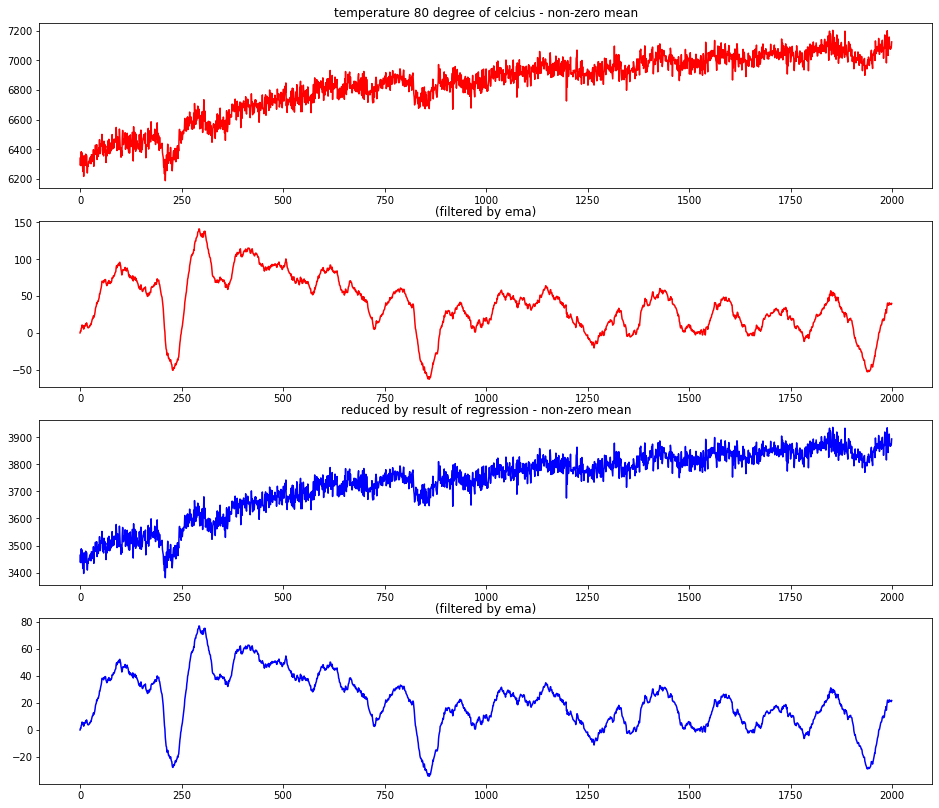

In [17]:
_values = np.stack(df.sensor.values, axis=0)
_values = _values[1500:3500]

# get non-zero mean
__mean_nz = np.apply_along_axis(lambda x: np.mean(x[x!=0]), 1, _values)
__min_nz =  np.apply_along_axis(lambda x: np.min(x[x!=0]), 1, _values)
__max_nz =  np.apply_along_axis(lambda x: np.max(x[x!=0]), 1, _values)
__std_nz =  np.apply_along_axis(lambda x: np.std(x[x!=0]), 1, _values)

# print(len(__mean_nz))
# print(df.shape)

df = pd.DataFrame({
    'timestamp': df['timestamp'].values[1500:3500],
    'mean': __mean_nz,
    'min': __min_nz,
    'max': __max_nz,
    'std': __std_nz
})
display(df)


__mean_sub_ema = signalgo.subtract_ema(__mean_nz, 0.01)
__mean_ema = signalgo.ema(__mean_sub_ema, 0.05)
# peaks = signalgo.get_peaks(__mean_ema)

plt.figure(figsize=(16, 14))
plt.subplot(4,1,1)
plt.plot(__mean_nz, color='red')
plt.title('temperature 80 degree of celcius - non-zero mean')
plt.subplot(4,1,2)
# plt.plot(__mean_sub_ema)
plt.plot(__mean_ema, color='red')
plt.title('(filtered by ema)')

__mean_rt = __mean_nz * RATIO
__mean_rt_sub_ema = signalgo.subtract_ema(__mean_rt, 0.01)
__mean_rt_ema = signalgo.ema(__mean_rt_sub_ema, 0.05)

plt.subplot(4,1,3)
plt.plot(__mean_rt, color='blue')
plt.title('reduced by result of regression - non-zero mean')
plt.subplot(4,1,4)
plt.plot(__mean_rt_ema, color='blue')
plt.title('(filtered by ema)')

In [18]:
sys.exit(1)

SystemExit: 1

/root/.pyenv/versions/python39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
